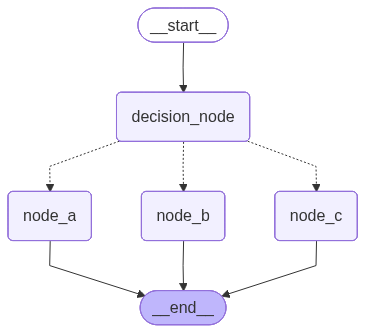

In [7]:
from langgraph.types import Command
from langgraph.graph import StateGraph, START, END
from typing import Literal
from typing_extensions import TypedDict

# 定义状态
class CommandState(TypedDict):
    input_data: str
    processed_data: str
    decision_result: str

def decide_next_node(state):
    """负责制定决策（去哪里）"""
    input_data = state['input_data'].lower()
    if 'process_a' in input_data:
        return 'node_a'
    elif 'process_b' in input_data:
        return 'node_b'
    else:
        return 'node_c'

def decision_node(state) -> Command[Literal["node_a", "node_b", "node_c"]]:
    # Command[Literal["node_a", "node_b", "node_c"]]表示：这个 Command 对象的 goto 参数只能跳转到这三个节点
    """
    使用 Command 的节点函数示例
    """
    # 处理输入数据
    input_data = state['input_data']
    processed_result = f"已处理: {input_data}"
    
    # 调用决策函数（核心关系）
    '''调用 decide_next_node函数，根据当前状态（state）中的输入数据来决定下一个应该执行的节点是哪个，
    并将这个决定（即下一个节点的名称）赋值给变量 next_node_name ,体现在 "decision_result" 状态更新'''
    next_node_name = decide_next_node(state)
    
    return Command(
        update={"processed_data": processed_result, "decision_result": f"决定跳转到: {next_node_name}"},  # 状态更新
        goto=next_node_name  # 流程跳转指令
    )

# 目标节点
def node_a(state):
    return {"processed_data": state['processed_data'] + " -> 经过节点A处理"}

def node_b(state):
    return {"processed_data": state['processed_data'] + " -> 经过节点B处理"}

def node_c(state):
    return {"processed_data": state['processed_data'] + " -> 经过节点C处理"}

# 构建使用 Command 的图
builder = StateGraph(CommandState)

# 添加节点
builder.add_node("decision_node", decision_node)
builder.add_node("node_a", node_a)
builder.add_node("node_b", node_b)
builder.add_node("node_c", node_c)

# 添加边
builder.add_edge(START, "decision_node")
# decision_node → node_a/node_b/node_c 是动态的（由 Command 决定）
builder.add_edge("node_a", END)
builder.add_edge("node_b", END)
builder.add_edge("node_c", END)

# 编译图
command_graph = builder.compile()
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

png_bytes = command_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API) #  使用 MermaidDrawMethod.API 指定使用 Mermaid.ink API 渲染
display(Image(png_bytes))

In [8]:
# 测试不同的输入
test_inputs = [
    "请执行 process_a 操作",
    "需要 process_b 处理",
    "其他类型的操作"
]

for input_data in test_inputs:
    print(f"\n输入数据: {input_data}")
    result = command_graph.invoke({"input_data": input_data})
    # update参数指定状态更新
    print(f"决策结果: {result.get('decision_result', '无')}")
    print(f"处理结果: {result.get('processed_data', '无')}")


输入数据: 请执行 process_a 操作
决策结果: 决定跳转到: node_a
处理结果: 已处理: 请执行 process_a 操作 -> 经过节点A处理

输入数据: 需要 process_b 处理
决策结果: 决定跳转到: node_b
处理结果: 已处理: 需要 process_b 处理 -> 经过节点B处理

输入数据: 其他类型的操作
决策结果: 决定跳转到: node_c
处理结果: 已处理: 其他类型的操作 -> 经过节点C处理


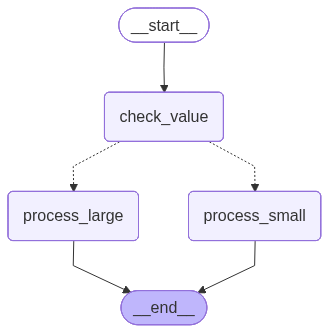

In [9]:
from langgraph.graph import StateGraph, START
from langgraph.types import Command
from typing import TypedDict, Literal

# 定义状态结构
class SimpleState(TypedDict):
    value: int
    result: str

# 节点A：判断数值大小并决定下一步
def check_value(state: SimpleState) -> Command[Literal["process_large", "process_small"]]:
    print(f"当前数值: {state['value']}")
    
    if state['value'] > 100:
        # 数值较大，跳转到process_large节点，并更新状态
        return Command(
            #update={"result": "检测到大数值"},
            goto="process_large"
        )
    else:
        # 数值较小，跳转到process_small节点
        return Command(
            #update={"result": "检测到小数值"},
            goto="process_small"
        )

# 处理大数值的节点
def process_large(state: SimpleState) -> SimpleState:
    final_result = f"大数值处理完成: {state['value']} * 10 = {state['value'] * 10}"
    return {"result": final_result}

# 处理小数值的节点
def process_small(state: SimpleState) -> SimpleState:
    final_result = f"小数值处理完成: {state['value']} + 100 = {state['value'] + 100}"
    return {"result": final_result}

# 构建工作流
builder = StateGraph(SimpleState)

# 添加节点
builder.add_node("check_value", check_value)
builder.add_node("process_large", process_large)
builder.add_node("process_small", process_small)

# 设置起点
builder.add_edge(START, "check_value")

# 编译图
graph = builder.compile()
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API) #  使用 MermaidDrawMethod.API 指定使用 Mermaid.ink API 渲染
display(Image(png_bytes))

In [5]:
# 测试工作流
print("=== 测试大数值 ===")
result1 = graph.invoke({"value": 150})
print(f"最终结果: {result1['result']}")

print("\n=== 测试小数值 ===")
result2 = graph.invoke({"value": 50})
print(f"最终结果: {result2['result']}")

=== 测试大数值 ===
当前数值: 150
最终结果: 大数值处理完成: 150 * 10 = 1500

=== 测试小数值 ===
当前数值: 50
最终结果: 小数值处理完成: 50 + 100 = 150
